N-Gram Models and their probabilities

A first step in making use of n-gram models is using them to estimate the probabilities of certain events.

In order to make use of these models we will first want to count the words in a document.

In [1]:
import nltk.data
from os import listdir
from os.path import isfile, join
from nltk.util import bigrams 
from nltk.tokenize import TreebankWordTokenizer
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
treebank_tokenizer = TreebankWordTokenizer()

dir_base = "/Users/teacher/repos/s20_ds_nlp/classes/week_3/data/"


def read_file(filename):
    input_file_text = open(filename , encoding='utf-8').read()
    return input_file_text

    
def read_directory_files(directory):
    file_texts = ""
    files = [f for f in listdir(directory) if isfile(join(directory, f))]
    for f in files:
        file_texts += read_file(join(directory, f) )
    return file_texts
    
text_corpus = read_directory_files(dir_base)
print(text_corpus)




June 5, 2018  —



Objective:
We determined whether U.S. Pacific Command (USPACOM) and subordinate commands developed, reviewed, and validated requirements for the Philippines Operations Support Contract (POSC) III to ensure the adequate provision of services.
Background:
On February 23, 2017, Naval Facilities Engineering Command Pacific awarded the POSC III. This contract is a cost-plus-incentive-fee contract with a maximum dollar value of $58 million, including the base year and four option periods with a 6‑month extension, to provide base operating support services. 
In September 2017, the Secretary of Defense designated Operation Pacific Eagle‑Philippines as a contingency operation. USPACOM, in coordination with other DoD elements, government agencies, and partner nations, executes this contingency operation as a counterterrorism campaign supporting the Republic of the Philippines. 
In order to execute the POSC III, constant communication and collaboration are required among Nav

So now we have a single text variable that represents all the text in a corpus.

Can we get counts and what not of this?

In [2]:
bigrams = nltk.bigrams(text_corpus)
freq_bi = nltk.FreqDist(bigrams)

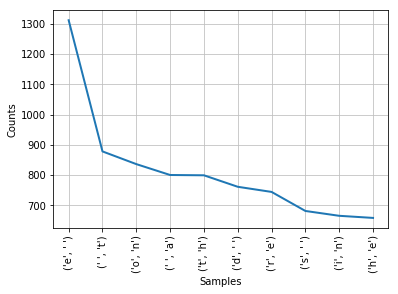

In [4]:
freq_bi.plot(10)

What's the problem with this data?

Characters only.

In [5]:
punkt_sentences = sentence_tokenizer.tokenize(text_corpus)
sentences_words = [treebank_tokenizer.tokenize(sentence) for sentence in punkt_sentences]
all_tokens = [word for sentence in sentences_words for word in sentence]
bigrams = nltk.bigrams(all_tokens)
freq_bi = nltk.FreqDist(bigrams)

[(('of', 'the'), 65), ((',', 'and'), 57), (('.', 'The'), 40), (('did', 'not'), 38), (('that', 'the'), 34), ((',', 'the'), 32), (('for', 'the'), 23), (('with', 'the'), 23), (('Air', 'Force'), 23), (('contracting', 'officers'), 22), (('.', 'In'), 21), (('’', 's'), 21), ((',', 'we'), 20), (('In', 'addition'), 17), (('addition', ','), 17), (('and', 'the'), 17), (('Berry', 'Amendment'), 17), (('contracting', 'personnel'), 16), (('in', 'the'), 15), (('.', 'We'), 15)]


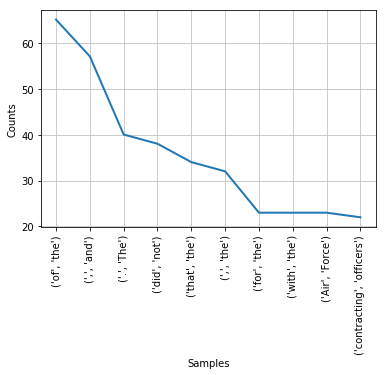

In [6]:
print(freq_bi.most_common(20))
freq_bi.plot(10)

In [7]:
stop_words = nltk.corpus.stopwords.words('english')
content = [w for w in all_tokens if w.lower() not in stop_words]
bigrams = nltk.bigrams(content)
freq_bi = nltk.FreqDist(bigrams)

[(('Air', 'Force'), 23), (('contracting', 'officers'), 22), (('addition', ','), 17), (('Berry', 'Amendment'), 17), (('.', 'addition'), 16), (('contracting', 'personnel'), 16), (('software', 'development'), 14), (('Director', ','), 14), ((',', '2017'), 13), (('.', 'Specifically'), 13), (('Specifically', ','), 13), (('Buy', 'American'), 13), (('American', 'Act'), 13), ((',', 'Defense'), 13), ((',', 'DCMA'), 13), (('business', 'case'), 12), (('Defense', 'Logistics'), 12), (('Logistics', 'Agency'), 12), (('DCMA', 'officials'), 12), (('case', 'analysis'), 11)]


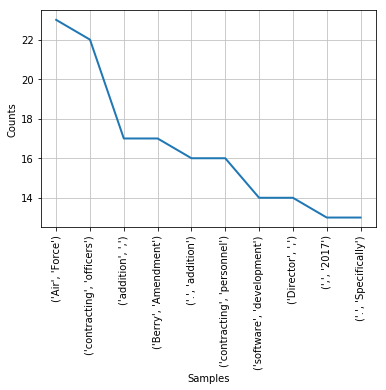

In [8]:
print(freq_bi.most_common(20))
freq_bi.plot(10)

What other things might we remove?

Numbers? Punctuation?

In [ ]:
print(freq_bi.hapaxes())
print(freq_bi.N())
print(freq_bi.freq(('May','21')))

Moving from frequency counts to probabilities

Above we used the NLTK library to count the number of tokens and n-grams. We can now fit a probability distribution to this data to determine the probability of different tokens and n-grams.

In [9]:
# use the Maximum Likelihood Estimator to construct 
# a probability distribution for things.
MLE_Dist = nltk.MLEProbDist(freq_bi)
print(MLE_Dist.max()) # tell us what the most likely item is.
print(MLE_Dist.prob(('Air', 'Force'))) # regular probability
print(MLE_Dist.logprob(('Air', 'Force')) ) # log probability

('Air', 'Force')
0.004333082140165787
-7.850390699313181


But what if we use words that we've never seen before?

In [10]:
print(MLE_Dist.prob(('Chair', 'Force')))
print(MLE_Dist.logprob(('Chair', 'Force')) )

0.0
-1e+300


Knowing that we can construct a probability distribution, we can also smooth the distribution to avoid the zero probability problem.

In [11]:
# Take the frequency counts and fit them into a 
# probability with Laplacean smoothing
Smoothed_dist = nltk.LaplaceProbDist(freq_bi)
print(Smoothed_dist.prob(('Chair', 'Force')))
print(Smoothed_dist.logprob(('Chair', 'Force')) )

0.00011519410206197443
-13.083645526864414


Now we can generate random strings from the model.

In [12]:
print(Smoothed_dist.generate())

('allegations', 'focused')


Now, imagine you have a sentence and you want to see about identifying its source. You have two separate language models you've constructed and so you are going to calculate the probability that a novel sentence has come from one of these models.

In [13]:
import numpy as np
test_sentence_1 = "USPACOM, in coordination with other DoD elements, government agencies, and partner nations, executes this contingency operation as a counterterrorism campaign supporting the Republic of the Philippines. "
test_sentence_2 = "Quite unexpectedly, my curiosity turned into a foray into postmodern philosophy and critical theory, reflexivity and voice, various vague approaches to autobiographical inquiry, validity and acceptability, defences and criticisms, and a wide range of published personal narratives, the typical product of autoethnography."

def get_sentence_bigrams(sentence):
    sentence_words = treebank_tokenizer.tokenize(sentence)
    word_count = len(sentence_words)
    bigrams = nltk.bigrams(sentence_words)
    return bigrams, word_count
    
def estimate_sentence_probability(bigram_sentence, word_length):
    slogprob = 0
    for bigram_words in bigram_sentence:
        logprob= Smoothed_dist.logprob(bigram_words)
        slogprob += logprob
     
    return slogprob/word_length

bigram_sentence,word_count = get_sentence_bigrams(test_sentence_1)
estimate_probability = estimate_sentence_probability(bigram_sentence, word_count)
print(estimate_probability)
print(np.exp(estimate_probability))



bigram_sentence_2,word_count = get_sentence_bigrams(test_sentence_2)
estimate_probability_2 = estimate_sentence_probability(bigram_sentence_2, word_count)
print(estimate_probability_2)
print(np.exp(estimate_probability_2))



-12.172240025951295
5.1720572600635855e-06
-12.821972616327125
2.7007727658579358e-06


Do these numbers look right?

In [14]:
def get_better_sentence_bigrams(sentence):
    sentence_words = treebank_tokenizer.tokenize(sentence)
    stop_words = nltk.corpus.stopwords.words('english')
    content = [w for w in sentence_words if w.lower() not in stop_words]
    word_count = len(sentence_words)
    bigrams = nltk.bigrams(content)
    return bigrams, word_count
    

bigram_sentence, word_count = get_better_sentence_bigrams(test_sentence_1)
estimate_probability = estimate_sentence_probability(bigram_sentence, word_count)
print(estimate_probability)
print(np.exp(estimate_probability))


bigram_sentence, word_count = get_better_sentence_bigrams(test_sentence_2)
estimate_probability = estimate_sentence_probability(bigram_sentence, word_count)
print(estimate_probability)
print(np.exp(estimate_probability))

-7.707033001133059
0.0004496536217073315
-9.15855186880509
0.00010531529804417424
